In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
from aacgmv2 import convert_mlt
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,7,5)
timeStart = datetime.datetime(2011,7,5,3,0)
timeEnd = datetime.datetime(2011,7,5,7,0)
sapsTime = datetime.datetime(2011,7,5,5,2)
sapsTimeRange = [ datetime.datetime(2011,7,5,4,0),\
              datetime.datetime(2011,7,5,6,0) ]
sapsMlatRange = [ 52., 63. ]#[ 56., 60. ]
velMagnScale = [ 0, 1000 ]
coords="mlt"
# TEC variables
tecScale = [ 0, 10 ]
# discard the edge MLTs
# these are the MLTs we'll plot
# pltNormMltList = [ -4, -3, -2, -1, 0 ]

In [3]:
def round2(number):
    """
    Round a number to the closest half integer.
    """
    return round(number * 2) / 2

def get_west_vel(row):
    westVel = row['vLos']/( numpy.cos(\
                 numpy.deg2rad( 90.-\
                    row['azimCalcMag'] ) ) )
    if westVel >= 2000.:
        return numpy.nan
    return westVel


def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )


def get_mlon_from_mlt(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    if row["endPtnormMlt"] < 0: 
        currEndptMLT = row["endPtnormMlt"] + 24.
    else:
        currEndptMLT = row["endPtnormMlt"]
    row["Mlon"] = numpy.round( \
                        convert_mlt( currMLT, row["date"] , m2a=True ) )
    if row["Mlon"] > 180.:
        row["Mlon"] -= 360.
    row["EndptMlon"] = numpy.round( \
                        convert_mlt( currEndptMLT, row["date"] , m2a=True ) )
    if row["EndptMlon"] > 180.:
        row["EndptMlon"] -= 360.
    return row

def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

In [4]:
# read from sd L-shell Vecs from the feather file
lshellDF = feather.read_dataframe('../data/lshellFits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
lshellDF = lshellDF[ (lshellDF["velSAPS"] > 0.) &\
                    (lshellDF["velSAPS"] < 2000.) ].reset_index(drop=True)
lshellDF["endPtmlat"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["mlat"], 2)
lshellDF["endPtnormMlt"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["normMlt"], 2)
lshellDF = lshellDF.apply( get_mlon_from_mlt, axis=1 )
lshellDF.head()

,azimSAPS,azimSTD,delMLT,goodFit,mlat,normMlt,velSAPS,velSTD,endPtMLAT,endPtNormMLT,date,endPtmlat,endPtnormMlt,Mlon,EndptMlon
0,15.083845,6.610516,1.5,True,59.0,-2.0,349.126369,33.397030,58.91,-2.34,2011-07-05 04:00:00,58.91,-2.34,-17.0,-22.0
1,15.704863,2.943747,1.5,True,59.0,-3.0,345.693567,19.495890,58.91,-3.33,2011-07-05 04:00:00,58.91,-3.33,-32.0,-37.0
2,4.222649,3.620818,1.5,True,59.5,-2.0,303.585017,29.043018,59.48,-2.30,2011-07-05 04:00:00,59.48,-2.30,-17.0,-22.0
3,19.073163,1.517291,1.5,True,58.5,-4.0,391.855314,28.287167,58.37,-4.37,2011-07-05 04:00:00,58.37,-4.37,-47.0,-53.0
4,15.200143,1.697521,1.5,True,59.0,-4.0,355.620902,23.967516,58.91,-4.34,2011-07-05 04:00:00,58.91,-4.34,-47.0,-52.0


In [5]:
ampSCWDF = feather.read_dataframe('../data/amp-scw-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
ampSCWDF["scwNormMLTDown"] = [ x-24 if x>12 else x for x in ampSCWDF["scwMLTDown"] ]
ampSCWDF["scwNormMLTUp"] = [ x-24 if x>12 else x for x in ampSCWDF["scwMLTUp"] ]
ampSCWDF.head()

,scwJrDown,scwJrUp,scwLocDates,scwLocMlatDown,scwLocMlatUp,scwMLTDown,scwMLTUp,scwNormMLTDown,scwNormMLTUp
0,-0.49,0.15,2011-07-05 03:00:00,60.0,64.0,20.0,20.0,-4.0,-4.0
1,-0.47,0.57,2011-07-05 03:00:00,61.0,65.0,21.0,21.0,-3.0,-3.0
2,-0.16,0.48,2011-07-05 03:00:00,56.0,60.0,23.0,23.0,-1.0,-1.0
3,-0.06,0.37,2011-07-05 03:00:00,56.0,60.0,0.0,0.0,0.0,0.0
4,-0.11,0.48,2011-07-05 03:00:00,56.0,60.0,1.0,1.0,1.0,1.0


In [6]:
# get a timeseries plot of the vectors
# for a given time, get max vectors at each MLT
selCols = [ 'normMlt', 'velSAPS', 'azimSAPS', 'date' ]
meanVelDF = lshellDF[selCols].groupby(\
            [ 'normMlt', 'date' ] \
            ).mean().reset_index()
meanVelDF["time"] = [ date2num(x) for x in meanVelDF["date"] ]
meanVelDF["endPtTime"] = (meanVelDF["velSAPS"]/2e5) *\
                                numpy.cos( numpy.deg2rad(\
                                -90-1*meanVelDF["azimSAPS"]) ) +\
                                meanVelDF["time"]
meanVelDF["endPtnormMlt"] = numpy.round( (meanVelDF["velSAPS"]/2000.) *\
                                numpy.sin( numpy.deg2rad(\
                                -90-1*meanVelDF["azimSAPS"]) ) +\
                                meanVelDF["normMlt"], 2 )
meanVelDF = meanVelDF[ ( meanVelDF["date"] >= sapsTimeRange[0] ) &\
               ( meanVelDF["date"] <= sapsTimeRange[1] )\
               ].reset_index(drop=True)
meanVelDF = meanVelDF[ meanVelDF["normMlt"] > -6 ].reset_index(drop=True)

meanVelDF.head()

,normMlt,date,velSAPS,azimSAPS,time,endPtTime,endPtnormMlt
0,-5.0,2011-07-05 04:12:00,311.796453,-6.383196,734323.175000,734323.175173,-5.15
1,-5.0,2011-07-05 04:14:00,325.582796,-8.181915,734323.176389,734323.176621,-5.16
2,-5.0,2011-07-05 04:16:00,565.203887,-8.969217,734323.177778,734323.178218,-5.28
3,-5.0,2011-07-05 04:22:00,1015.226356,-14.060453,734323.181944,734323.183178,-5.49
4,-5.0,2011-07-05 04:24:00,829.103941,-15.187118,734323.183333,734323.184419,-5.40


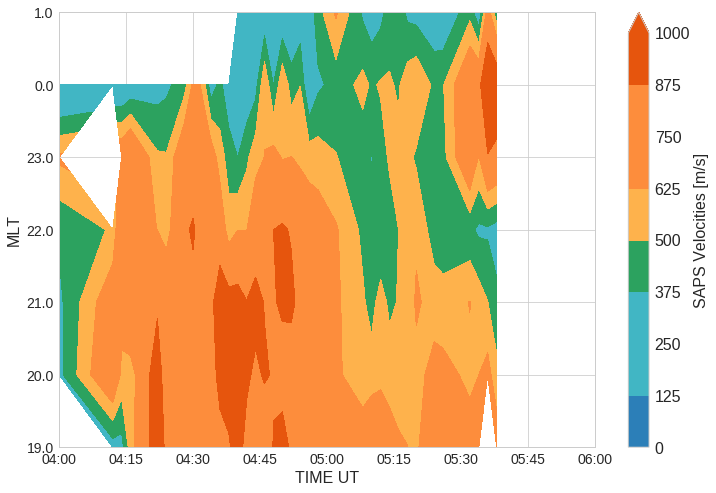

In [20]:
# setup data
plotMLTends = meanVelDF['endPtnormMlt'].tolist()#meanVelDF['endPtMlon'].tolist()#
plotmlatends = meanVelDF['endPtTime'].tolist()
plotMLTbegins = meanVelDF['normMlt'].tolist()#meanVelDF['Mlon'].tolist()#
plotmlatbegins = meanVelDF['time'].tolist()
plotVelMagns = meanVelDF['velSAPS'].tolist()
# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
# set colorbar
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# set a few standard xticks
yTickList = []
currTime = sapsTimeRange[0]
while currTime <= sapsTimeRange[1]:
    yTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
    
    
# lshellPlot = ax.scatter( x=meanVelDF["time"], y=meanVelDF["normMlt"],\
#                      c=meanVelDF["velSAPS"],cmap=seaMap,\
#                      vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

plotDF = meanVelDF[ ["time", "normMlt",\
                        "velSAPS"] ].pivot( "time", "normMlt" )

timeVals = plotDF.index.values
nMltVals = plotDF.columns.levels[1].values


timeCntr, nMltCntr  = numpy.meshgrid( timeVals, nMltVals )
# Mask the nan values! pcolormesh can't handle them well!
vMagnVals = numpy.ma.masked_where(numpy.isnan(plotDF["velSAPS"].values),\
                                  plotDF["velSAPS"].values)

# rtiPlot = ax.pcolormesh(timeCntr.T, nMltCntr.T , vMagnVals,\
#                         cmap=seaMap, vmin=velMagnScale[0],vmax=velMagnScale[1])

rtiPlot = ax.contourf(timeCntr.T, nMltCntr.T , vMagnVals,\
                        cmap=seaMap, levels=numpy.linspace(0, 1000, 9), extend='max',\
                      vmin=velMagnScale[0],\
                      vmax=velMagnScale[1])
ax.set_xlim( sapsTimeRange )
# ax.set_xlim( [ -80, 0 ] )
ax.set_xlabel("TIME UT", fontsize=16)
ax.set_ylabel("MLT", fontsize=16)
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
        
cb = plt.colorbar(rtiPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel('SAPS Velocities [m/s]', fontsize=16)


# f.savefig("../plots/lshell-mean-timseries-" +\
#             sapsTime.strftime("%Y%m%d") +\
#             ".pdf" ,bbox_inches='tight')

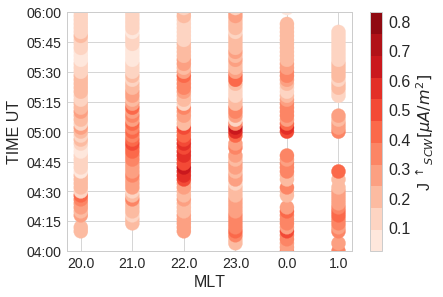

In [21]:
sns.set_style("whitegrid")
sns.set_context("paper")
colList = [ "firebrick", "seagreen", "#2c7fb8" ]
seaMap = ListedColormap(sns.color_palette("Reds",11))

fig = plt.figure()
ax = fig.add_subplot(111)

ampSCWPlot = ax.scatter( x=ampSCWDF["scwNormMLTUp"].values, y=ampSCWDF["scwLocDates"].values,\
          c=ampSCWDF["scwJrUp"].values, cmap=seaMap,s=200 )

ax.set_ylim( sapsTimeRange )
ax.set_ylabel("TIME UT", fontsize=16)
ax.set_xlabel("MLT", fontsize=16)
ax.get_yaxis().set_major_formatter(DateFormatter('%H:%M'))
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
        
cb = plt.colorbar(ampSCWPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel(r"J $^{\uparrow}$$_{SCW} [\mu A/m^{2}]$", fontsize=16)